In [69]:
#import dependencies

import pandas as pd
import requests
from bs4 import BeautifulSoup as bs
import time
from pprint import pprint as pp
import sqlite3
import warnings
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, roc_curve, roc_auc_score, f1_score, precision_recall_curve, average_precision_score, auc
from sklearn.svm import SVC, SVR
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense
from matplotlib import pyplot
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt



In [28]:
# create connection to database
warnings.filterwarnings('ignore')

con = sqlite3.connect("db/movies.db")
sql = f"""
   SELECT * FROM movie_data
   """

# bring in db to pandas dataframe
movieDf = pd.read_sql(sql, con)
movieDf.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,actor_2_score,actor_3_score,imdb_num_code,release_date,success_bins,production_companies_count,genres_count,popularity,vote_count,vote_average
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,1.747604,2.066294,tt0499549,2009-12-10,extreme success,4.0,4,185.070892,12114.0,7.2
1,Color,Stephen Sommers,106.0,106.0,208.0,855.0,Jason Flemyng,3000.0,11146409.0,Action|Adventure|Horror|Sci-Fi,...,5.825346,2.066294,tt0118956,1998-01-30,no success,3.0,4,6.922458,155.0,6.0
2,Color,Terrence Malick,222.0,150.0,0.0,855.0,Michael Greyeyes,23000.0,12712093.0,Biography|Drama|History|Romance,...,0.582535,2.066294,tt0402399,2005-12-25,no success,5.0,3,7.694502,336.0,6.4
3,Color,Brian Robbins,76.0,98.0,48.0,722.0,Joel David Moore,21000.0,61112916.0,Comedy|Family|Fantasy,...,1.747604,2.066294,tt0393735,2006-03-09,moderate success,3.0,2,4.878907,138.0,4.5
4,Color,Brad Peyton,178.0,94.0,62.0,722.0,Dwayne Johnson,14000.0,103812241.0,Action|Adventure|Comedy|Family|Fantasy|Sci-Fi,...,1.747604,2.066294,tt1397514,2012-01-19,average success,3.0,3,9.46307,1050.0,5.8


In [29]:
# review columns
movieDf.columns

Index(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users', 'cast_total_facebook_likes',
       'actor_3_name', 'facenumber_in_poster', 'plot_keywords',
       'movie_imdb_link', 'num_user_for_reviews', 'language', 'country',
       'content_rating', 'budget', 'title_year', 'actor_2_facebook_likes',
       'imdb_score', 'aspect_ratio', 'movie_facebook_likes', 'revenue',
       'gross_margin', 'successful', 'rating_numeric', 'director_score',
       'actor_1_score', 'actor_2_score', 'actor_3_score', 'imdb_num_code',
       'release_date', 'success_bins', 'production_companies_count',
       'genres_count', 'popularity', 'vote_count', 'vote_average'],
      dtype='object')

In [74]:
# create table for model purposes
modelDf = movieDf[["duration","facenumber_in_poster","rating_numeric","budget","revenue","gross_margin", "successful","director_score","production_companies_count","actor_1_score"]]
modelDf = modelDf.dropna()

modelDf.head(100)

,duration,facenumber_in_poster,rating_numeric,budget,revenue,gross_margin,successful,director_score,production_companies_count,actor_1_score
0,178.0,0.0,3,237000000.0,523505847.0,0.688365,1,3.091853,4.0,1.520767
1,106.0,0.0,4,45000000.0,-33853591.0,-3.037175,0,1.766773,3.0,3.041534
2,150.0,0.0,3,30000000.0,-17287907.0,-1.359958,0,1.325080,5.0,8.364217
3,98.0,0.0,2,50000000.0,11112916.0,0.181842,1,2.650160,3.0,9.884984
4,94.0,3.0,2,79000000.0,24812241.0,0.239011,1,1.325080,3.0,2.661342
5,146.0,4.0,4,100000000.0,-4671063.0,-0.048999,0,0.441693,4.0,0.760383
6,90.0,0.0,3,25000000.0,-6139597.0,-0.325528,0,2.650160,1.0,0.380192
7,121.0,0.0,4,83000000.0,-16137932.0,-0.241362,0,2.208466,1.0,1.520767
8,101.0,1.0,4,42000000.0,-28791977.0,-2.179885,0,0.883387,8.0,0.760383
9,110.0,1.0,4,45000000.0,25001065.0,0.357153,1,0.883387,4.0,0.760383


In [75]:
modelDf["successful"].value_counts()

1    1950
0    1687
Name: successful, dtype: int64

In [76]:
# Assign X (data) and y (target)
X = modelDf[["rating_numeric","director_score","production_companies_count","actor_1_score"]]
y = modelDf["successful"].values.reshape(-1, 1)
print(X.shape, y.shape)

(3637, 4) (3637, 1)


In [77]:
# split the training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1158, train_size=0.9, stratify=y)

# Create a StandardScater model and fit it to the training data
X_scaler = StandardScaler().fit(X_train)

In [78]:
pd.DataFrame(y_test)[0].value_counts()

1    195
0    169
Name: 0, dtype: int64

In [79]:
# transform the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Logistic Regression Model 

In [37]:
#build logistic model 
model = LogisticRegression()

#fit on training data
model.fit(X_train_scaled, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [38]:
# Use our model to predict a value
predicted = model.predict(X_test_scaled)

# Score the prediction with mse and r2
mse = mean_squared_error(y_test, predicted)
r2 = r2_score(y_test, predicted)
testing_score = model.score(X_test_scaled,y_test)

print(f"testing_score: {testing_score}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2 ): {r2}")

testing_score: 0.5906593406593407
Mean Squared Error (MSE): 0.40934065934065933
R-squared (R2 ): -0.6457593688362921


# Deep Neural Network

In [86]:
# creating the empty squential network
modelNN = Sequential()

In [87]:
# Add the first layer where the input dimensions are the 3 columns of the training data
modelNN.add(Dense(units=16, activation='relu', input_dim=4))

In [88]:
# Add the hidden layer
modelNN.add(Dense(units=16, activation='relu'))

In [89]:
# Add output layer, 2 units for "classes" of output, i.e. Yes or No 
modelNN.add(Dense(units=2, activation='softmax'))

In [90]:
# Compile the model using the adaptive learning rate optimizer "adam", spare_categorical_crossentropy
# for the loss function since we did not one-hot encode the labels and used accuracy for the training metrics.
modelNN.compile(optimizer='adadelta',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [91]:
# Use the training data to fit (train) the model
modelNN.fit(
    X_train_scaled,
    y_train,
    epochs=200,
    shuffle=True,
    verbose=2
)

Epoch 1/200
 - 0s - loss: 0.6895 - acc: 0.5509
Epoch 2/200
 - 0s - loss: 0.6814 - acc: 0.5616
Epoch 3/200
 - 0s - loss: 0.6789 - acc: 0.5613
Epoch 4/200
 - 0s - loss: 0.6765 - acc: 0.5671
Epoch 5/200
 - 0s - loss: 0.6762 - acc: 0.5771
Epoch 6/200
 - 0s - loss: 0.6747 - acc: 0.5768
Epoch 7/200
 - 0s - loss: 0.6738 - acc: 0.5805
Epoch 8/200
 - 0s - loss: 0.6729 - acc: 0.5836
Epoch 9/200
 - 0s - loss: 0.6723 - acc: 0.5857
Epoch 10/200
 - 0s - loss: 0.6716 - acc: 0.5857
Epoch 11/200
 - 0s - loss: 0.6718 - acc: 0.5869
Epoch 12/200
 - 0s - loss: 0.6711 - acc: 0.5826
Epoch 13/200
 - 0s - loss: 0.6708 - acc: 0.5878
Epoch 14/200
 - 0s - loss: 0.6700 - acc: 0.5826
Epoch 15/200
 - 0s - loss: 0.6703 - acc: 0.5830
Epoch 16/200
 - 0s - loss: 0.6695 - acc: 0.5848
Epoch 17/200
 - 0s - loss: 0.6698 - acc: 0.5863
Epoch 18/200
 - 0s - loss: 0.6699 - acc: 0.5860
Epoch 19/200
 - 0s - loss: 0.6687 - acc: 0.5866
Epoch 20/200
 - 0s - loss: 0.6689 - acc: 0.5885
Epoch 21/200
 - 0s - loss: 0.6689 - acc: 0.5842
E

Epoch 171/200
 - 0s - loss: 0.6579 - acc: 0.5964
Epoch 172/200
 - 0s - loss: 0.6576 - acc: 0.6010
Epoch 173/200
 - 0s - loss: 0.6575 - acc: 0.5988
Epoch 174/200
 - 0s - loss: 0.6575 - acc: 0.6004
Epoch 175/200
 - 0s - loss: 0.6579 - acc: 0.5915
Epoch 176/200
 - 0s - loss: 0.6573 - acc: 0.5991
Epoch 177/200
 - 0s - loss: 0.6581 - acc: 0.6010
Epoch 178/200
 - 0s - loss: 0.6575 - acc: 0.5949
Epoch 179/200
 - 0s - loss: 0.6571 - acc: 0.5973
Epoch 180/200
 - 0s - loss: 0.6573 - acc: 0.5933
Epoch 181/200
 - 0s - loss: 0.6571 - acc: 0.6022
Epoch 182/200
 - 0s - loss: 0.6571 - acc: 0.6010
Epoch 183/200
 - 0s - loss: 0.6571 - acc: 0.5921
Epoch 184/200
 - 0s - loss: 0.6568 - acc: 0.6001
Epoch 185/200
 - 0s - loss: 0.6572 - acc: 0.5958
Epoch 186/200
 - 0s - loss: 0.6569 - acc: 0.5976
Epoch 187/200
 - 0s - loss: 0.6564 - acc: 0.6007
Epoch 188/200
 - 0s - loss: 0.6565 - acc: 0.5927
Epoch 189/200
 - 0s - loss: 0.6562 - acc: 0.5943
Epoch 190/200
 - 0s - loss: 0.6566 - acc: 0.5988
Epoch 191/200
 - 0s 

In [92]:
# evaluate model by using test data
model_loss, model_accuracy = modelNN.evaluate(
    X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

 - 0s - loss: 0.6714 - acc: 0.5907
Loss: 0.6714287636044262, Accuracy: 0.5906593203544617


# Calculate ROC Curve vs Precision Recall Curve

##### Generally, the use of ROC curves and precision-recall curves are as follows:
#### ROC curves should be used when there are roughly equal numbers of observations for each class.
#### Precision-Recall curves should be used when there is a moderate to large class imbalance.

In [103]:
# predict probabilities
probs = modelNN.predict_proba(X_test_scaled)
# keep probabilities for the positive outcome only
probs = probs[:, 1]

In [48]:
# calculate AUC
auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc)

AUC: 0.589


In [49]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)

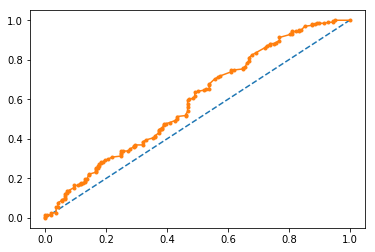

In [50]:
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

# Precision Recall Curve

In [53]:
# predict class values
yClass = model.predict(X_test_scaled)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, probs)
# calculate F1 score
f1 = f1_score(y_test, yClass)
# calculate precision-recall AUC
auc = auc(recall, precision)
# calculate average precision score
ap = average_precision_score(y_test, probs)
print('f1=%.3f auc=%.3f ap=%.3f' % (f1, auc, ap))

f1=0.697 auc=0.602 ap=0.604


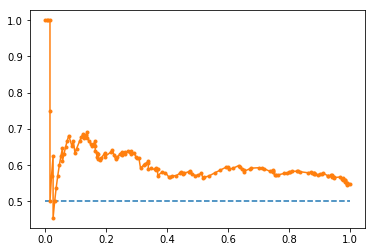

In [54]:
# plot no skill
pyplot.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the precision-recall curve for the model
pyplot.plot(recall, precision, marker='.')
# show the plot
pyplot.show()

# Grid Search / Cross Validation

In [57]:
# import dependencies from sklearn, build model using "rbf" kernel for the support vector classifier and bring in
# hyperparameters "C" and "gamma"

from sklearn.model_selection import GridSearchCV
modelGS = SVC(kernel='rbf')
param_grid = {'C': [.01, 1, 10, 100, 1000],
              'gamma': [0.0001, 0.001, 0.01,]}
grid = GridSearchCV(modelGS, param_grid, verbose=3)

In [58]:
grid.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] C=0.01, gamma=0.0001 ............................................
[CV] ................ C=0.01, gamma=0.0001, score=0.536, total=   0.1s
[CV] C=0.01, gamma=0.0001 ............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ................ C=0.01, gamma=0.0001, score=0.536, total=   0.1s
[CV] C=0.01, gamma=0.0001 ............................................
[CV] ................ C=0.01, gamma=0.0001, score=0.536, total=   0.1s
[CV] C=0.01, gamma=0.001 .............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


[CV] ................. C=0.01, gamma=0.001, score=0.536, total=   0.1s
[CV] C=0.01, gamma=0.001 .............................................
[CV] ................. C=0.01, gamma=0.001, score=0.536, total=   0.1s
[CV] C=0.01, gamma=0.001 .............................................
[CV] ................. C=0.01, gamma=0.001, score=0.536, total=   0.1s
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .................. C=0.01, gamma=0.01, score=0.536, total=   0.1s
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .................. C=0.01, gamma=0.01, score=0.536, total=   0.1s
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .................. C=0.01, gamma=0.01, score=0.536, total=   0.1s
[CV] C=1, gamma=0.0001 ...............................................
[CV] ................... C=1, gamma=0.0001, score=0.536, total=   0.1s
[CV] C=1, gamma=0.0001 ...............................................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    6.2s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.01, 1, 10, 100, 1000],
                         'gamma': [0.0001, 0.001, 0.01]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [59]:
# Linear SVC - best parameters and score for the data
print(grid.best_params_)
print(grid.best_score_)

{'C': 1000, 'gamma': 0.01}
0.563091964558509


# Decision Tree Model

In [94]:
clf = tree.DecisionTreeClassifier()

In [95]:
# Fit the classifier to the data
clf = clf.fit(X_train_scaled, y_train)

In [96]:
# Calculate the R2 score for the test data
r2 = clf.score(X_test, y_test)

print(f"R2: {r2}")

R2: 0.532967032967033


# Random Forest Model

In [97]:
# Create, fit, and score a Random Forest Classifier
rf = RandomForestClassifier(n_estimators=500)
rf = rf.fit(X_train_scaled, y_train)
rf.score(X_test_scaled, y_test)

0.5576923076923077

In [100]:
# validating scores
from sklearn import metrics
prediction=rf.predict(X_test_scaled)
print("Accuracy:",metrics.accuracy_score(prediction,y_test))

Accuracy: 0.5576923076923077


In [101]:
#Hyper Parameters Set for decision tree
params = {'max_features': ['auto', 'sqrt', 'log2'],
          'min_samples_split': [2,3,4,5,6,7,8,9,10,11,12,13,14,15], 
          'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10,11],
          'random_state':[123]}

In [102]:
#Making models with hyper parameters sets
model1 = GridSearchCV(rf, param_grid=params, n_jobs=-1)
#Learning
model1.fit(X_train_scaled,y_train)
#The best hyper parameters set
print("Best Hyper Parameters:",model1.best_params_)
#Prediction
prediction=model1.predict(X_test_scaled)
#evaluation(Accuracy)
print("Accuracy:",metrics.accuracy_score(prediction,y_test))

Best Hyper Parameters: {'max_features': 'auto', 'min_samples_leaf': 11, 'min_samples_split': 2, 'random_state': 123}
Accuracy: 0.5686813186813187


In [98]:
print(rf.feature_importances_)

[0.10020941 0.25455084 0.2154515  0.42978825]


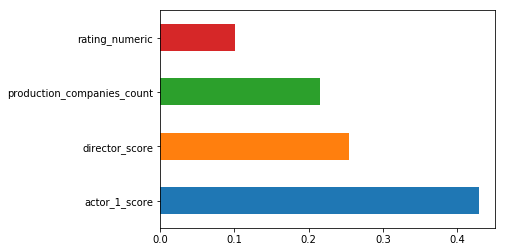

In [99]:
#plot graph of feature importances for better visualization
feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()